## Лабораторная работа №5. Решение задач классификации с помощью байесовского классификатора и метода k-ближайших соседей.
### Часть 1. Гауссов наивный байесовский классификатор.

Используемый набор данных: [Wine](https://archive.ics.uci.edu/ml/datasets/Wine)

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from itertools import cycle
import os
import requests

%matplotlib inline

pd.options.display.max_columns = None

In [2]:
def downloadFile(url, filePath):
    if not os.path.exists(filePath):
        req = requests.get(url)
        f = open(filePath, "wb")
        f.write(req.content)
        f.close

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine"
downloadFile(url + "/wine.data", "dataset/wine.data")
downloadFile(url + "/wine.names", "dataset/wine.names")

In [3]:
headers = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
           "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]  
data = pd.read_csv("dataset/wine.data", names=headers)
data["Class"] = data["Class"].astype("category")
data.sample(40)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
131,3,12.88,2.99,2.40,20.0,104,1.30,1.22,0.24,0.83,5.40,0.74,1.42,530
105,2,12.42,2.55,2.27,22.0,90,1.68,1.84,0.66,1.42,2.70,0.86,3.30,315
118,2,12.77,3.43,1.98,16.0,80,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372
90,2,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480
57,1,13.29,1.97,2.68,16.8,102,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270
34,1,13.51,1.80,2.65,19.0,110,2.35,2.53,0.29,1.54,4.20,1.10,2.87,1095
50,1,13.05,1.73,2.04,12.4,92,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150
135,3,12.60,2.46,2.20,18.5,94,1.62,0.66,0.63,0.94,7.10,0.73,1.58,695
115,2,11.03,1.51,2.20,21.5,85,2.46,2.17,0.52,2.01,1.90,1.71,2.87,407
97,2,12.29,1.41,1.98,16.0,85,2.55,2.50,0.29,1.77,2.90,1.23,2.74,428


In [4]:
display(data.isna().sum())
display(data.describe())

Class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Пропусков в данных нет.

Подготовим данные для классификации: выберем признаки и метки и сформируем тренировочные и тестовые наборы.

In [5]:
classes = data["Class"].unique()
n_classes = len(classes)
y = label_binarize(data["Class"], classes=classes)
X = data.drop(columns=["Class"]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

Создадим классификатор, обучим его, а затем выполним классификацию.

In [6]:
 y_score = OneVsRestClassifier(GaussianNB()).fit(X_train, y_train).predict(X_test)

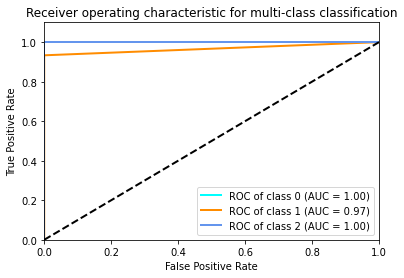

In [7]:
fpr, tpr, auc = dict(), dict(), dict()
for i in range(n_classes):
    y_test_cl = y_test[:,i]
    y_score_cl = y_score[:,i]
    fpr[i], tpr[i], _ = roc_curve(y_test_cl, y_score_cl)
    auc[i] = roc_auc_score(y_test_cl, y_score_cl)
    
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC of class {0} (AUC = {1:0.2f})'.format(i, auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class classification')
plt.legend(loc="lower right")
plt.show()